<center> <img src=https://github.com/PIno-1963/CIT---INPT---DATA-CELL/blob/main/1%20-%20CIT-DATA-101/CIT-DATA-HEADER.png?raw=true> </center>

<center><h1 >Scraping Data</h1></center>

Welcome to this notebook, where we will explore the exciting journey of web scraping images from [Unsplash](Unsplash.com) and utilizing them to train a Deep Learning (DL) model. Unsplash is a vast repository of high-quality images, making it an ideal source for diverse datasets.

In this notebook, our primary objectives are:

**Data Scraping:**
We will leverage web scraping techniques to gather images from Unsplash. Specifically, we'll focus on scraping images from two distinct classes to build a diverse dataset.

**Data Preprocessing:**
After obtaining the images, we'll perform essential preprocessing tasks such as resizing, normalizing, and organizing the data to prepare it for model training.

**Deep Learning Model:**
We'll design and train a DL model using a popular framework TensorFlow. The model will be tailored to classify images belonging to the two classes we scraped.

**Model Evaluation:**
Once the model is trained, we'll assess its performance using evaluation metrics and visualize its predictions on unseen data.
By the end of this notebook, you'll have gained hands-on experience in web scraping, data preprocessing, and building and training a DL model for image classification. Let's dive in and unlock the potential of extracting knowledge from the vast visual resources available on Unsplash!







In [ ]:
!pip install pathlib

## Importing dependencies

In [ ]:
from bs4 import BeautifulSoup
import requests
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import cv2
import os
from pathlib import Path
from tqdm import tqdm

### EX1 :

Create a directory named "images," and within it, add two subdirectories named as the chosen classes.

In [ ]:
!mkdir images
!mkdir images/pencil
!mkdir images/money

## Creating Scraping functions

### EX2:

Write a Python function that downloads content and saves it as an image file. The function should take three parameters:

- data: The binary content of the image.
- category: The name of the class or category for organizing the images.
- filename: The name of the image file.

The function should save the image file in the "/content/images/" directory, within a subdirectory named after the specified category.




In [ ]:
def download_image(image_content, class_name, file_name):
    with open(f"/content/images/{class_name}/" + file_name + ".jpeg" , "wb") as im:
        im.write(image_content)

### EX3


write a function that send a Get request to an URL and return the response content.

In [ ]:
def get_data(url):
  return requests.get(url).content


### EX4

Create a function that accepts a JSON response from Unsplash and extracts all image links contained within that response.

In [ ]:
def get_images_links(response):
    items = response["results"]
    for item in items:
        yield item["urls"]["small"]

### EX5

Create a function that orchestrates the entire process, covering the following steps:

1. **Getting Data from the Unsplash API:**
   Fetch data from the Unsplash API to acquire information about images.

2. **Extracting Image Links from the Response:**
  Parse the JSON response from Unsplash to extract links to the images.

3. **Downloading Each Image to the Correct Path:**
   Iterate through the extracted image links and download each image, placing them in the appropriate path.


In [ ]:
def scrap_images(class_name, user_agent):

    num_scraped_images = 0

    for i in tqdm(range(50)):

        response = get_data(
            f"""https://unsplash.com/napi/search/photos?query={class_name}&
                                per_page=30&page={i}&xp=search-synonym%3Acontrol""",
            user_agent
        )

        response_json = json.loads(response)
        images_links = get_images_links(response_json)

        for link in images_links:
            try:
                image = get_data(link, user_agent)
                download_image(image, class_name, f'{num_scraped_images:03}')
                num_scraped_images += 1

            except:
                continue

Let's proceed to download the images for the selected classes.

In [ ]:
for cls in ["money", "pencil"]:
    scrap_images(cls)

 58%|█████▊    | 29/50 [01:41<01:55,  5.52s/it]

<center><h1>Working with CNN</h1></center>

In this section, we will utilize the scraped data to train a model for image classification.

First, we should create a DataFrame that organizes image paths and labels based on the directory structure, making it easier to work with the data for tasks such as image classification.

In [ ]:
path = Path("/content/images/")

db = {"image": [] , "label": []}

classes = os.listdir(path)

for cls in classes:

  images = os.listdir(path / cls)
  db["image"].extend([*map(lambda x : str(path/ cls / x), images)])
  db["label"].extend([cls]*len(images))

db = pd.DataFrame(db)
db.sample(5)

### EX6

Visualize the distribution of images across each class by plotting a bar chart.

In [ ]:
import plotly.express as px
fig=px.bar(db.groupby("label").count())
fig.show()

split the DataFrame into training and testing sets.

In [ ]:
X_train , X_test = train_test_split(db,test_size=.3,random_state=42)

visualize some images from training set

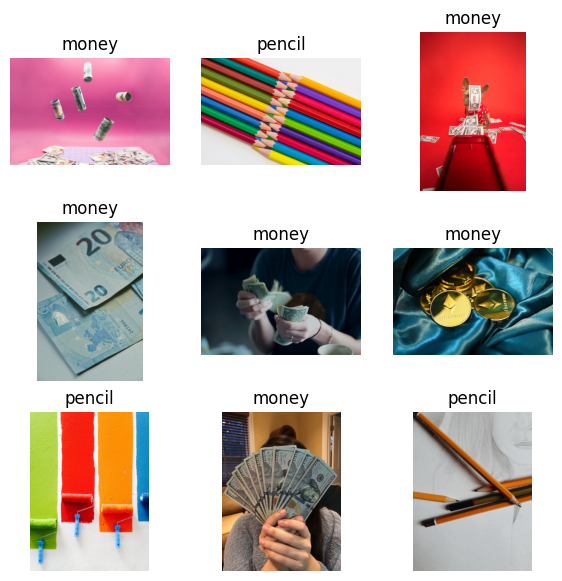

In [ ]:
samples = X_train.sample(9)

plt.figure(figsize=(7,7))
for i in range(9):
  plt.subplot(3,3, i + 1)
  plt.imshow(cv2.cvtColor(cv2.imread(samples.iloc[i,0]), cv2.COLOR_RGB2BGR))
  plt.title(samples.iloc[i,1])
  plt.axis("off")
plt.show()

This code is using the ImageDataGenerator from TensorFlow's Keras API to generate batches of image data for training and testing. It is specifically designed to work with data stored in a Pandas DataFrame.

In [ ]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(

)

x_train = img_gen.flow_from_dataframe(dataframe=X_train,
                                      x_col="image",
                                      y_col="label",
                                      shuffle = False,
                                      target_size=(224,224))

x_test = img_gen.flow_from_dataframe(dataframe=X_test,
                                     x_col="image",
                                     y_col="label",
                                     shuffle= False,
                                     target_size=(224,224))

Found 700 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


Let's proceed with building our model. Given that we might not have sufficient data to train a model from scratch, we will employ a 'weight extraction' approach using EfficientNetB0. This involves utilizing the pre-trained weights from EfficientNetB0 as a starting point for our model.

In [ ]:
effnet = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                              include_top=False,input_shape=(224,224,3))

effnet.trainable = False

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
input = tf.keras.layers.Input((224,224,3))
x = effnet(input)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(rate=0.4)(x)
x = tf.keras.layers.Flatten()(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)
model = tf.keras.models.Model(inputs = input , outputs = output)

let's compile our model using the Categorical Crossentropy loss function, the Adam optimizer with a specified learning rate, and accuracy as the metric.

In [ ]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics = ["accuracy"])

print("model compiled!")

model compiled!


now let's train our model, but first we should ensure that training will be terminated  once the model's performance on a validation dataset stops improving, we will use an EarlyStopping.

In [ ]:
earlystop = EarlyStopping(
                  monitor="val_loss",
                  patience=5,
                  verbose=1
            )

In [ ]:
history = model.fit(x_train,
                    validation_data=x_test,
                    batch_size=32,
                    epochs=5,
                    shuffle= True,
                    callbacks=[earlystop])

### Model Evaluation

In [ ]:
loss,accuracy = model.evaluate(x_test)

print("loss:",loss)
print("Accuracy:",accuracy)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

classes = x_test.class_indices

predictions = [*map(lambda x: np.argmax(x),model.predict(x_test ,verbose = 0))]

true_labels = [*map(lambda x: classes[x] , X_test["label"].values)]

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes.keys())

disp.plot(cmap = "Blues")
plt.show()

## Testing model on data from Internet

In [ ]:
classes = list(x_train.class_indices.keys())

def predict(image_url):
    global classes

    img = cv2.imread(image_name)
    img = cv2.resize(img, (224,224))

    prediction = model.predict(img.reshape(1,224,224,3),
                               verbose = 0)

    pred_class = classes[np.argmax(prediction)]
    prob = np.max(prediction) * 100

    # show the image and the prediction
    plt.imshow(cv2.cvtColor(img , cv2.COLOR_BGR2RGB))
    plt.title(pred_class + " " + str(prob) + "%")
    plt.axis("off")
    plt.show()


In [ ]:
!wget -O money.png https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ3-hM9wq0_xgIA2BFXXQ1zpq57RW0dMOlCQA&usqp=CAU

In [ ]:
predict("money.png")